# Histopathologic Cancer Detection

## Problem Description

In this Kaggle competition, we are supplied with images of pathology scans.  Some of the images contain tumor tissue, while other images do not.  The goal of this project is to classigy images into one of those two lables (binary classification).

The training data includes 220,025 images in .tif format, and their labels.  The images are all 64 x 64 pixels, and contain 3 layers (RGB).

## Imports and Utility Code

In [1]:
from PIL import Image
import numpy as np # linear algebra
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Code to clean up the Kaggle working directory as needed:

In [2]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)

Image pre-processing function.  This function performs the following:
- Conditionally converts the image to greyscale (converting it from 3 RGB layers to a single, greyscale, layer).
- Resizes the image
- Normalizes the pixel weights (Color in the original image is represented from 0 to 255)

In [3]:
def preprocess_tiff_image(file_path, greyscale=True, target_size=(64, 64)):
    image = Image.open(file_path)
    if greyscale:
        image = image.convert('L')
    image = image.resize(target_size)
    image = np.array(image) / 255.0
    return image

# Exploratory Data Analysis

## Sample Submission and Train Labels Review

Quick look at the sample submission file, so I understand what I need to produce.  The expected submission file is simply the image id (filename) and the predicted label.

In [4]:
sample_submission = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
sample_submission

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0
57454,6f3977130212641fd5808210015a609c658dcbff,0
57455,46935f247278539eca74b54d07d666efb528a753,0
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0


The training labels file is below. This file contains one row for each image in the train directory.  The id column is the filename, and the label is the actual label (whether or not there is tumor tissue in the image).

In [5]:
train_labels = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
train_labels

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


The lables are a bit unbalanced (130,908 images without tumor tissue, 89,117 images with tumor tissue).  I account for this unbalance in the data preparation code below.

label
0    130908
1     89117
Name: count, dtype: int64

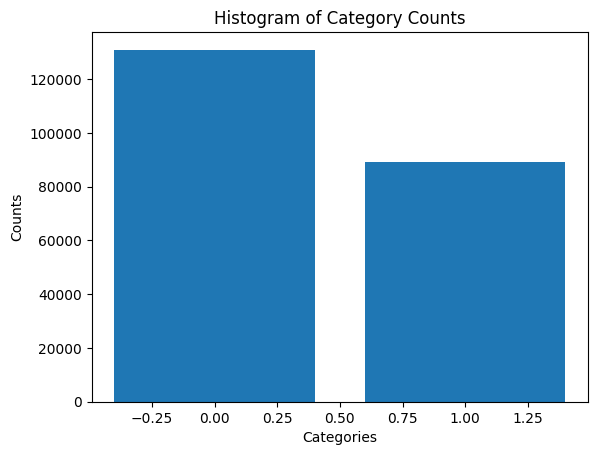

In [6]:
value_counts = train_labels['label'].value_counts()
display(value_counts)

plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Histogram of Category Counts')
plt.show()

## Image Review

A quick review of a couple images in the dataset.

### Negative and Postive Images Review

#### label=0 Image

A label=0 image is seen below.  While I'm not trained in medicine, there does not appear to be any dark spots I might suspect might be tumor tissue.

I've also noted that there are three RGB color channels in the image (seen in the image shape below).

Image Shape (64, 64, 3)


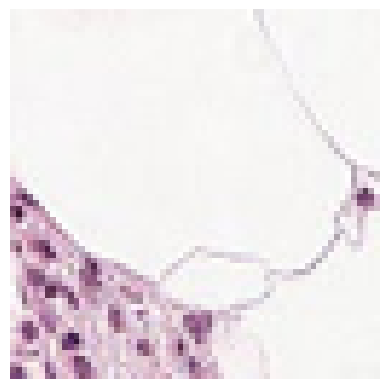

In [7]:
image_path = "/kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif"
image = preprocess_tiff_image(image_path, greyscale=False)
print(f'Image Shape {image.shape}')
plt.imshow(image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#### label=1 Image

Again, I'm not trained in medicine, however a label=1 image does show some distinct dark areas which I might have guessed is tumor tissue.

Image Shape (64, 64, 3)


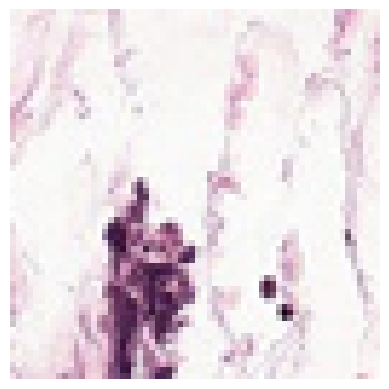

In [8]:
image_path = "/kaggle/input/histopathologic-cancer-detection/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif"
image = preprocess_tiff_image(image_path, greyscale=False)
print(f'Image Shape {image.shape}')
plt.imshow(image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#### Converted to Single Color Dimension (Greyscale)

Reviewing the images above, color does not appear to be a critically important factor here.  The data that is important is the intensity and shape of the artifacts in the image.  With that, I'll be converting all of the images to a single color channel (greyscale) as part of my pre-processing steps.

Image Shape (64, 64)


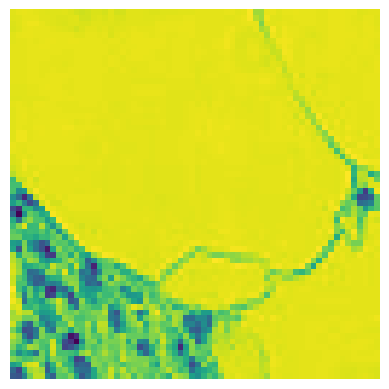

In [9]:
image_path = "/kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif"
image = preprocess_tiff_image(image_path, greyscale=True)
print(f'Image Shape {image.shape}')
plt.imshow(image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# Image Pre-processing

Below, I do the following:
- The memory in Kaggle and processing time is limited.  To effectively manage memory and processing time, I'm going to limit the train data to only 10,000 images.  In addition, because I noticed the data was a bit unbalanced above, I will be balancing the dataset into 5000 randomly selected images with label 1, and 5000 randomly selected images with label 0.

To preprocess, I run my pre-processing function on all of the images (which converts them to greyscale and normalizes them), and store that in a Pandas Dataframe.

In [10]:
sample_size = 5000
#sample_size = 100

data_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
#tiff_files = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.tif')]

# Sample only 50,000 images since the entire dataset exceeds memory contraints.

train_data_1 = train_labels[train_labels['label'] == 1].sample(sample_size, random_state=1000)
train_data_0 = train_labels[train_labels['label'] == 0].sample(sample_size, random_state=1000)
train_data = pd.concat([train_data_1, train_data_0])

train_data['image_data'] = train_data.progress_apply(lambda row: preprocess_tiff_image(data_dir + row['id'] + '.tif'), axis=1)

current_datetime = datetime.now().strftime('%Y%m%d%H%M%S')
output_file = f'/kaggle/working/preprocessed_data_{current_datetime}.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(train_data, file)

100%|██████████| 10000/10000 [01:14<00:00, 134.50it/s]


In [11]:
output_file = f'/kaggle/working/preprocessed_data_{current_datetime}.pkl'
with open(output_file, 'rb') as file:
    train_data = pickle.load(file)

# Model

## Model Construction, Grid Search, and Training

To construct the model, I've built a method that will allow me to adjust various architectures and hyperparameters in a grid search.

To attempt to find the best model (within the following limited parameters) I have run multiple models with the variations in the following:
- Adam optimizer
- Filter kernal sizes of 3x3 and 4x4
- 3 and 4 convolution layers
- Including and excluding layer normalization between each convolutional layer

Because the competition states that submission scoring is based on ROC-AUC, I am selecting the best model using that metric of all models attempted in the grid search.

In [12]:
def create_model(optimizer='adam', kernel_size=(3, 3), num_conv_layers=2, use_layer_norm=False):
    model = keras.Sequential()
    
    filters = 32
    
    for layer in range(1, num_conv_layers + 1):
        model.add(layers.Conv2D(filters, kernel_size, activation='relu'))
        if use_layer_norm:
            model.add(layers.LayerNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        filters *= 2
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_model)

# Define a set of hyperparameters and values to search
param_grid = {
    'optimizer': ['adam'],#, 'rmsprop'],
    'kernel_size': [(3, 3), (4, 4)],
    'num_conv_layers': [3, 4],
    'use_layer_norm': [True, False]
}

/tmp/ipykernel_67/145508731.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


In [13]:
images = np.array([np.expand_dims(img, axis=-1) for img in train_data['image_data']])
labels = np.array(train_data['label'])

random_order = np.arange(len(images))
np.random.shuffle(random_order)
images = images[random_order]
labels = labels[random_order]

test_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=2, verbose=3)
grid_search_result = grid_search.fit(images, labels, epochs=20, batch_size=32, callbacks=[test_callback])

print("Best Parameters: ", grid_search_result.best_params_)
print("Best Accuracy: ", grid_search_result.best_score_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Epoch 1/20
157/157 [==============================] - 16s 21ms/step - loss: 0.7010 - accuracy: 0.5922
Epoch 2/20
157/157 [==============================] - 3s 19ms/step - loss: 0.5277 - accuracy: 0.7456
Epoch 3/20
157/157 [==============================] - 3s 18ms/step - loss: 0.5339 - accuracy: 0.7424
Epoch 4/20
157/157 [==============================] - 3s 20ms/step - loss: 0.4902 - accuracy: 0.7700
Epoch 5/20
157/157 [==============================] - 3s 18ms/step - loss: 0.4930 - accuracy: 0.7722
Epoch 6/20
157/157 [==============================] - 3s 18ms/step - loss: 0.4988 - accuracy: 0.7678
Epoch 7/20
157/157 [==============================] - 3s 19ms/step - loss: 0.4830 - accuracy: 0.7774
Epoch 8/20
157/157 [==============================] - 3s 18ms/step - loss: 0.4631 - accuracy: 0.7938
Epoch 9/20
157/157 [==============================] - 3s 18ms/step - loss: 0.4748 - accuracy: 0.7812
Epoch 10/20
157/157 [=========

## Grid Search Results

Below, I've output the grid search results in full, sorted from best model to worst.  It appears that a larger kernal size (4,4), 4 convolutional layers, and layer normalization in place performed the best when using ROC-AUC as our metric (mean_test_score).

In [14]:
results_df = pd.DataFrame(grid_search_result.cv_results_)
sorted_results_df = results_df.sort_values(by='rank_test_score')
sorted_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel_size,param_num_conv_layers,param_optimizer,param_use_layer_norm,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
6,76.844517,7.978553,1.806653,0.048009,"(4, 4)",4,adam,True,"{'kernel_size': (4, 4), 'num_conv_layers': 4, ...",0.883316,0.842425,0.862871,0.020445,1
7,18.174459,7.648944,1.176725,0.461468,"(4, 4)",4,adam,False,"{'kernel_size': (4, 4), 'num_conv_layers': 4, ...",0.842787,0.853482,0.848134,0.005347,2
1,21.188663,0.596439,0.707144,0.014158,"(3, 3)",3,adam,False,"{'kernel_size': (3, 3), 'num_conv_layers': 3, ...",0.829571,0.850887,0.840229,0.010658,3
2,84.509717,0.265628,1.908687,0.006862,"(3, 3)",4,adam,True,"{'kernel_size': (3, 3), 'num_conv_layers': 4, ...",0.844323,0.820653,0.832488,0.011835,4
3,32.559340,9.775836,0.948001,0.025579,"(3, 3)",4,adam,False,"{'kernel_size': (3, 3), 'num_conv_layers': 4, ...",0.835044,0.813895,0.824470,0.010574,5
5,32.556559,9.684142,0.821473,0.094989,"(4, 4)",3,adam,False,"{'kernel_size': (4, 4), 'num_conv_layers': 3, ...",0.817653,0.815772,0.816713,0.000941,6
0,70.244745,6.347998,2.472006,0.563229,"(3, 3)",3,adam,True,"{'kernel_size': (3, 3), 'num_conv_layers': 3, ...",0.828233,0.791202,0.809717,0.018515,7
4,43.486464,21.536483,1.697820,0.027197,"(4, 4)",3,adam,True,"{'kernel_size': (4, 4), 'num_conv_layers': 3, ...",0.817389,0.500000,0.658694,0.158694,8


In [15]:
current_datetime = datetime.now().strftime('%Y%m%d%H%M%S')
grid_file = f'/kaggle/working/grid_{current_datetime}.pkl'
with open(grid_file, 'wb') as file:
    pickle.dump(grid_search_result, file)

In [16]:
grid_file = f'/kaggle/working/grid_{current_datetime}.pkl'
with open(grid_file, 'rb') as file:
    grid_search_result = pickle.load(file)

In [17]:
best_model = grid_search_result.best_estimator_

current_datetime = datetime.now().strftime('%Y%m%d%H%M%S')
model_file = f'/kaggle/working/model_{current_datetime}.pkl'
with open(model_file, 'wb') as file:
    pickle.dump(best_model, file)

In [18]:
model_file = f'/kaggle/working/model_{current_datetime}.pkl'
with open(model_file, 'rb') as file:
    best_model = pickle.load(file)

# Inference on Test Data

I begin inference by preparing the image data matching the model preparation above.

In [19]:
test_data_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

tiff_files = [f for f in os.listdir(test_data_dir) if f.endswith('.tif')]

data = {'id': [os.path.splitext(file)[0] for file in tiff_files]}

test_df = pd.DataFrame(data)

test_df['image_data'] = test_df.progress_apply(lambda row: preprocess_tiff_image(test_data_dir + row['id'] + '.tif'), axis=1)

current_datetime = datetime.now().strftime('%Y%m%d%H%M%S')
output_file = f'/kaggle/working/preprocessed_test_data_{current_datetime}.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(test_df, file)

100%|██████████| 57458/57458 [05:24<00:00, 177.12it/s]


To see how the model performs on a couple select images, I've output model predictions for a couple single images below.

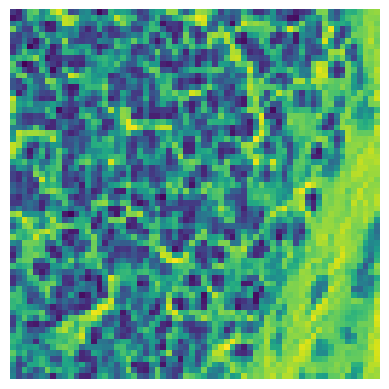

1/1 [==============================] - 1s 676ms/step


array([[0]])

In [20]:
img = test_df.iloc[1]['image_data']
plt.imshow(img)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()
image = np.array([np.expand_dims(img, axis=-1)])
display(best_model.predict(image))

Next, I run the prediction on all of the test images and save the results to my submission file.

In [21]:
images = np.array([np.expand_dims(img, axis=-1) for img in test_df['image_data']])
test_df['label'] = best_model.predict(images)
test_df['label'].value_counts()

1796/1796 [==============================] - 14s 8ms/step


label
1    30219
0    27239
Name: count, dtype: int64

In [22]:
current_datetime = datetime.now().strftime('%Y%m%d%H%M%S')
output_file = f'/kaggle/working/predicted_test_data_{current_datetime}.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(test_df, file)

In [23]:
test_df[['id', 'label']].to_csv('submission.csv', index=False)

# Conclusion

Grid search was a really effective way to test multiple configurations automatically.  While it's time consuming and computationally expensive, seeing the results of many hyperparameters and architectures is a great way to find the most performant models.

The primary issue keeping my model from performing better was due to the limited RAM and time.  To compensate for these limitations, I had to reduce the amount of training data and the permutations of options in my grid search.  Given more time and more computing power, I would expand the data to include the full library of images, and and attempt more options in my grid search.